In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Inference sigslipclassification

In [ ]:
!pip install -q transformers torch pillow gradio hf_xet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.0 MB/s eta 0:00:00


In [ ]:
from transformers import AutoImageProcessor, SiglipForImageClassification
from PIL import Image
import torch

# Load model and processor
model_name = "prithivMLmods/deepfake-detector-model-v1"
model = SiglipForImageClassification.from_pretrained(model_name)
processor = AutoImageProcessor.from_pretrained(model_name)

# Updated label mapping
id2label = {
    "0": "fake",
    "1": "real"
}

def classify_image(image):
    if isinstance(image, str):
        image = Image.open(image).convert("RGB")
    elif isinstance(image, np.ndarray):
        image = Image.fromarray(image).convert("RGB")
    elif isinstance(image, Image.Image):  # Already a PIL image
        image = image.convert("RGB")
    else:
        raise TypeError("Unsupported image type")
    inputs = processor(images=image, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=1).squeeze().tolist()

    prediction = {
        id2label[str(i)]: round(probs[i], 3) for i in range(len(probs))
    }

    return prediction


def classify_array_img(images):
  real_sc_arr=[]
  fake_sc_arr=[]
  for image in images:
    label = classify_image(image)
    fake_sc=label['fake']
    fake_sc_arr.append(fake_sc)
    real_sc=label['real']
    real_sc_arr.append(real_sc)
    print(label)

  print(f'real : {real_sc_arr} \n fake : {fake_sc_arr}')
  return real_sc_arr, fake_sc_arr

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/372M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split

REAL_PATH = "/content/drive/MyDrive/fake_generated_data/face_forensics/original/original_sequences/youtube/c23/videos"
FAKE_PATH = "/content/drive/MyDrive/fake_generated_data/face_forensics/manipulated_sequences/FaceShifter/c23/videos"
OUTPUT_FRAME_SIZE = (128, 128)  # Frame dimensions
FRAME_COUNT = 10  # Number of frames to extract per video
MAX_VIDEOS = 200  # Number of videos to process from each category

# Function to extract frames from a video
def extract_frames(video_path, output_size=(128, 128), frame_count=10):
    cap = cv2.VideoCapture(video_path)
    frames = []

    # simple version
    for i in range(frame_count):
      ret, frame = cap.read()
      if not ret:
        print("broke")
        break

      # Convert BGR (OpenCV) to RGB
      frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
      frames.append(frame_rgb)
    return frames

    #sampling version
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    step = max(total_frames // frame_count, 1)  # Uniform sampling

    for i in range(frame_count):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * step)
        ret, frame = cap.read()
        if not ret:
            break
        # frame = cv2.resize(frame, output_size)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame_rgb)
    cap.release()
    # return np.array(frames)
    return frames

# Prepare data and labels
data = []
labels = []
# video_path = '/content/drive/MyDrive/fake_generated_data/video_data/smile_blink.mp4'
# frames = extract_frames(video_path, output_size=OUTPUT_FRAME_SIZE, frame_count=FRAME_COUNT)
# type(frames)
print("Processing real videos...")
real_videos = os.listdir(REAL_PATH)[:MAX_VIDEOS]   # Limit to 300 videos
for video_file in tqdm(real_videos):
    video_path = os.path.join(REAL_PATH, video_file)
    frames = extract_frames(video_path, output_size=OUTPUT_FRAME_SIZE, frame_count=FRAME_COUNT)
    if len(frames) == FRAME_COUNT:  # Ensure correct frame count
        data.append(frames)
        labels.append(0)  # Label 0 for real

# Process fake videos
print("Processing fake videos...")
fake_videos = os.listdir(FAKE_PATH)[:MAX_VIDEOS]  # Limit to 300 videos
for video_file in tqdm(fake_videos):
    video_path = os.path.join(FAKE_PATH, video_file)
    frames = extract_frames(video_path, output_size=OUTPUT_FRAME_SIZE, frame_count=FRAME_COUNT)
    if len(frames) == FRAME_COUNT:
        data.append(frames)
        labels.append(1)  # Label 1 for fake


X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


Processing real videos...


100%|██████████| 200/200 [00:51<00:00,  3.87it/s]


Processing fake videos...


100%|██████████| 200/200 [01:01<00:00,  3.27it/s]


In [ ]:
y_test[1]

0

In [ ]:
def predict_image(img):
  real_scores, fake_scores = classify_array_img(img)
  real_avg = np.mean(real_scores)
  fake_avg = np.mean(fake_scores)
  return 0 if (real_avg>=fake_avg) else 1


In [ ]:
sc = predict_image(X_test[0])

{'fake': 0.524, 'real': 0.476}
{'fake': 0.528, 'real': 0.472}
{'fake': 0.545, 'real': 0.455}
{'fake': 0.55, 'real': 0.45}
{'fake': 0.564, 'real': 0.436}
{'fake': 0.56, 'real': 0.44}
{'fake': 0.565, 'real': 0.435}
{'fake': 0.552, 'real': 0.448}
{'fake': 0.535, 'real': 0.465}
{'fake': 0.534, 'real': 0.466}
real : [0.476, 0.472, 0.455, 0.45, 0.436, 0.44, 0.435, 0.448, 0.465, 0.466] 
 fake : [0.524, 0.528, 0.545, 0.55, 0.564, 0.56, 0.565, 0.552, 0.535, 0.534]


In [ ]:
sc

1

In [ ]:
# classify_image(X_test[0])
def predict(img_array):
  preds = []

  for img in img_array:
    score = predict_image(img)
    preds.append(score)


  return preds


y_pred = predict(X_test)
y_pred

{'fake': 0.524, 'real': 0.476}
{'fake': 0.528, 'real': 0.472}
{'fake': 0.545, 'real': 0.455}
{'fake': 0.55, 'real': 0.45}
{'fake': 0.564, 'real': 0.436}
{'fake': 0.56, 'real': 0.44}
{'fake': 0.565, 'real': 0.435}
{'fake': 0.552, 'real': 0.448}
{'fake': 0.535, 'real': 0.465}
{'fake': 0.534, 'real': 0.466}
real : [0.476, 0.472, 0.455, 0.45, 0.436, 0.44, 0.435, 0.448, 0.465, 0.466] 
 fake : [0.524, 0.528, 0.545, 0.55, 0.564, 0.56, 0.565, 0.552, 0.535, 0.534]
{'fake': 0.989, 'real': 0.011}
{'fake': 0.989, 'real': 0.011}
{'fake': 0.991, 'real': 0.009}
{'fake': 0.992, 'real': 0.008}
{'fake': 0.991, 'real': 0.009}
{'fake': 0.989, 'real': 0.011}
{'fake': 0.989, 'real': 0.011}
{'fake': 0.989, 'real': 0.011}
{'fake': 0.988, 'real': 0.012}
{'fake': 0.988, 'real': 0.012}
real : [0.011, 0.011, 0.009, 0.008, 0.009, 0.011, 0.011, 0.011, 0.012, 0.012] 
 fake : [0.989, 0.989, 0.991, 0.992, 0.991, 0.989, 0.989, 0.989, 0.988, 0.988]
{'fake': 0.985, 'real': 0.015}
{'fake': 0.984, 'real': 0.016}
{'fake': 0

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [ ]:

from sklearn.metrics import classification_report, accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Precision, Recall, F1-Score
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['REAL', 'FAKE']))

Test Accuracy: 45.00%
Classification Report:
              precision    recall  f1-score   support

        REAL       0.00      0.00      0.00        33
        FAKE       0.45      1.00      0.62        27

    accuracy                           0.45        60
   macro avg       0.23      0.50      0.31        60
weighted avg       0.20      0.45      0.28        60



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from PIL import Image
import cv2

# image = cv2.imread('/content/sc6.png')
image = Image.open('/content/sc3.png').convert("RGB")
classify_image(image)

{'fake': 0.715, 'real': 0.285}

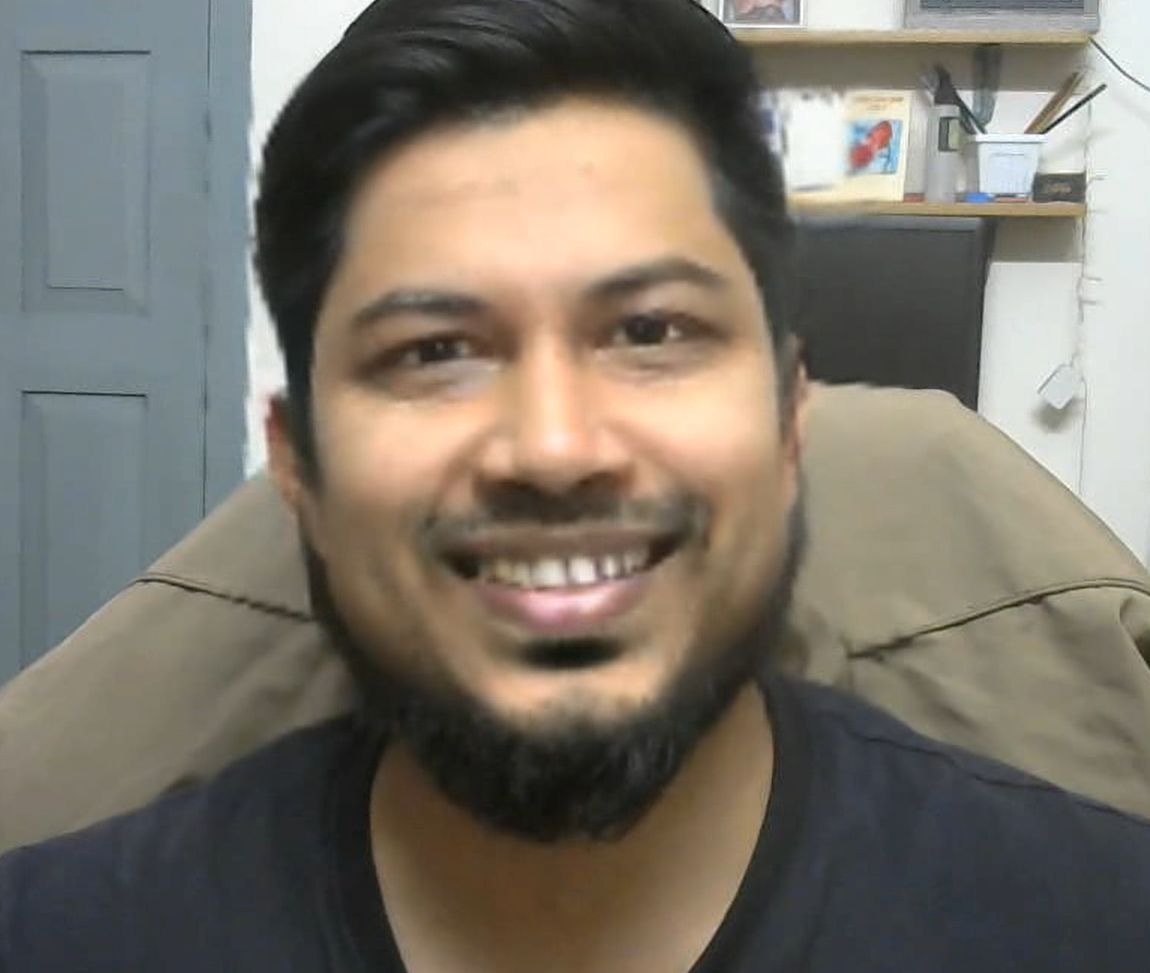

In [ ]:
image

# Fine tune

In [ ]:
print('fine tune')

fine tune


In [2]:
!pip install  transformers==4.49.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 84.8 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.54.0
    Uninstalling transformers-4.54.0:
      Successfully uninstalled transformers-4.54.0


In [3]:
!pip install -q evaluate datasets accelerate
!pip install -q huggingface_hub
!pip install -q numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.5 MB/s eta 0:00:00


In [ ]:
# only on v-8tpu
!pip install -q pillow==11.0.0
!pip install -q torchvision
!pip install -q matplotlib
!pip install -q scikit-learn
!pip install -q imbalanced-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 5.6 MB/s eta 0:00:00


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import gc
import numpy as np
import pandas as pd
import itertools
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, f1_score
from imblearn.over_sampling import RandomOverSampler
import evaluate
from datasets import Dataset, Image, ClassLabel, load_dataset
from transformers import (
    TrainingArguments,
    Trainer,
#....................................................................

#Retain this part if you are working on ViTForImageClassification.
    ViTImageProcessor,
    ViTForImageClassification,

#....................................................................

    DefaultDataCollator
)
from transformers.image_utils import load_image
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomRotation,
    RandomResizedCrop,
    RandomHorizontalFlip,
    RandomAdjustSharpness,
    Resize,
    ToTensor
)
from PIL import Image, ExifTags, ImageFile

In [ ]:
# only on v-8tpu
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 18.8 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from PIL import Image

REAL_PATH = "/content/drive/MyDrive/fake_generated_data/face_forensics/original/original_sequences/youtube/c23/videos"
FAKE_PATH = "/content/drive/MyDrive/fake_generated_data/face_forensics/manipulated_sequences/FaceShifter/c23/videos"
OUTPUT_FRAME_SIZE = (256, 256)  # Frame dimensions
FRAME_COUNT = 10  # Number of frames to extract per video
MAX_VIDEOS = 200  # Number of videos to process from each category

# Function to extract frames from a video
def extract_frames(video_path, output_size=(256, 256), frame_count=10):
    cap = cv2.VideoCapture(video_path)
    frames = []

    # simple version
    for i in range(frame_count):
      ret, frame = cap.read()
      if not ret:
        print("broke")
        break

      # Convert BGR (OpenCV) to RGB
      frame = cv2.resize(frame, output_size)
      frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
      # image = Image.fromarray(frame_rgb).convert("RGB")
      frames.append(frame_rgb)
    return np.array(frames)

    #sampling version
    # total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    # step = max(total_frames // frame_count, 1)  # Uniform sampling

    # for i in range(frame_count):
    #     cap.set(cv2.CAP_PROP_POS_FRAMES, i * step)
    #     ret, frame = cap.read()
    #     if not ret:
    #         break
    #     frame = cv2.resize(frame, output_size)
    #     frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    #     frames.append(frame_rgb)
    # cap.release()
    # return np.array(frames)
    # return frames

# Prepare data and labels
data = []
labels = []
# video_path = '/content/drive/MyDrive/fake_generated_data/video_data/smile_blink.mp4'
# frames = extract_frames(video_path, output_size=OUTPUT_FRAME_SIZE, frame_count=FRAME_COUNT)
# type(frames)
print("Processing real videos...")
real_videos = os.listdir(REAL_PATH)[:MAX_VIDEOS]   # Limit to 300 videos
for video_file in tqdm(real_videos):
    video_path = os.path.join(REAL_PATH, video_file)
    frames = extract_frames(video_path, output_size=OUTPUT_FRAME_SIZE, frame_count=FRAME_COUNT)
    if len(frames) == FRAME_COUNT:  # Ensure correct frame count
        data.extend(frames)  # Flatten into 1D list
        labels.extend([0] * FRAME_COUNT)  # One label per frame
    # if len(frames) == FRAME_COUNT:  # Ensure correct frame count
    #     data.append(frames)
    #     labels.append(0)  # Label 0 for real

# Process fake videos
print("Processing fake videos...")
fake_videos = os.listdir(FAKE_PATH)[:MAX_VIDEOS]  # Limit to 300 videos
for video_file in tqdm(fake_videos):
    video_path = os.path.join(FAKE_PATH, video_file)
    frames = extract_frames(video_path, output_size=OUTPUT_FRAME_SIZE, frame_count=FRAME_COUNT)
    if len(frames) == FRAME_COUNT:
        data.extend(frames)
        labels.extend([1] * FRAME_COUNT)  # Label 1 for fake


X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

Processing real videos...


100%|██████████| 200/200 [00:23<00:00,  8.63it/s]


Processing fake videos...


100%|██████████| 200/200 [00:23<00:00,  8.58it/s]


In [ ]:
X_train[0].shape


(128, 128, 3)

In [ ]:
# save to disk and create dataset from disk
import os
import numpy as np
import gc

np_dir = '/content/drive/MyDrive/fake_generated_data/numpy_data'
def save_np_array_to_disk(array, path):
  os.makedirs(path, exist_ok=True)
  paths = []
  for i, x in enumerate(array):
      out_path = f"frame_{i}.npy"
      final_out_path = os.path.join(path, out_path)
      np.save(final_out_path, x.astype(np.uint8))
      paths.append(out_path)

  return paths

def save_np_commpressed(array,labels,path):
  os.makedirs(path, exist_ok=True)
  final_out_path = os.path.join(np_dir, path)
  np.savez_compressed(
    final_out_path,
    X=array,
    y=labels
  )

train_path = "train_np_data.npz"
val_path = "val_np_data.npz"
test_path = "test_np_data.npz"

save_train_paths = save_np_commpressed(X_train,y_train, train_path)
del X_train
gc.collect()
save_val_paths = save_np_commpressed(X_val,y_val, val_path)
del X_val
gc.collect()
save_test_paths = save_np_commpressed(X_test,y_test, test_path)
del X_test
gc.collect()





0

In [ ]:
save_train_paths

['frame_0.npy',
 'frame_1.npy',
 'frame_2.npy',
 'frame_3.npy',
 'frame_4.npy',
 'frame_5.npy',
 'frame_6.npy',
 'frame_7.npy',
 'frame_8.npy',
 'frame_9.npy',
 'frame_10.npy',
 'frame_11.npy',
 'frame_12.npy',
 'frame_13.npy',
 'frame_14.npy',
 'frame_15.npy',
 'frame_16.npy',
 'frame_17.npy',
 'frame_18.npy',
 'frame_19.npy',
 'frame_20.npy',
 'frame_21.npy',
 'frame_22.npy',
 'frame_23.npy',
 'frame_24.npy',
 'frame_25.npy',
 'frame_26.npy',
 'frame_27.npy',
 'frame_28.npy',
 'frame_29.npy',
 'frame_30.npy',
 'frame_31.npy',
 'frame_32.npy',
 'frame_33.npy',
 'frame_34.npy',
 'frame_35.npy',
 'frame_36.npy',
 'frame_37.npy',
 'frame_38.npy',
 'frame_39.npy',
 'frame_40.npy',
 'frame_41.npy',
 'frame_42.npy',
 'frame_43.npy',
 'frame_44.npy',
 'frame_45.npy',
 'frame_46.npy',
 'frame_47.npy',
 'frame_48.npy',
 'frame_49.npy',
 'frame_50.npy',
 'frame_51.npy',
 'frame_52.npy',
 'frame_53.npy',
 'frame_54.npy',
 'frame_55.npy',
 'frame_56.npy',
 'frame_57.npy',
 'frame_58.npy',
 'frame

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
from transformers import AutoImageProcessor
from transformers import SiglipForImageClassification

# Use AutoImageProcessor instead of AutoProcessor
model_str = "google/siglip2-base-patch16-224"
processor = AutoImageProcessor.from_pretrained(model_str)

# Extract preprocessing parameters
image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

# Define training transformations
_train_transforms = Compose([
    Resize((size, size)),
    RandomRotation(90),
    RandomAdjustSharpness(2),
    ToTensor(),
    Normalize(mean=image_mean, std=image_std)
])

# Define validation transformations
_val_transforms = Compose([
    Resize((size, size)),
    ToTensor(),
    Normalize(mean=image_mean, std=image_std)
])





preprocessor_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
labels_list = ['example_label_1', 'example_label_2']

label2id, id2label = {}, {}
for i, label in enumerate(labels_list):
    label2id[label] = i
    id2label[i] = label

ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)


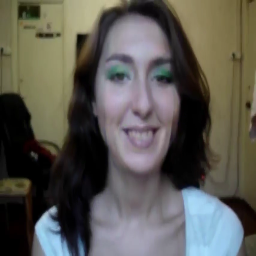

In [ ]:
Image.fromarray(np.array(X_train[0])).convert("RGB")

In [ ]:
from datasets import Dataset
import gc


x_train_list = [x.astype(np.uint8).tolist() for x in X_train]  # (H, W, 3) or (3, H, W)
y_train_list = [int(y) for y in y_train]
del X_train
gc.collect()
x_val_list = [x.astype(np.uint8).tolist() for x in X_val]  # (H, W, 3) or (3, H, W)
y_val_list = [int(y) for y in y_val]
del X_val
gc.collect()
train_dict = {"text": x_train_list, "label": y_train_list}
val_dict = {"text": x_val_list, "label": y_val_list}

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_dict(train_dict)
del train_dict
gc.collect()
train_dataset = train_dataset.shuffle(seed=42)
val_dataset = Dataset.from_dict(val_dict)
del val_dict
gc.collect()


In [ ]:
import gc
del X_train
del X_val
del train_dict
del val_dict
gc.collect()

NameError: name 'X_train' is not defined

In [ ]:
type(train_dataset[0]['text'][0])

list

In [ ]:
arr = np.array(train_dataset[0]['text'], dtype=np.uint8)
img = Image.fromarray(arr).convert("RGB")

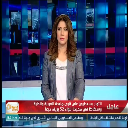

In [ ]:
img

In [ ]:
len(save_train_paths)

2800

In [ ]:
import os

train_path = "/content/drive/MyDrive/fake_generated_data/numpy_data/train"
val_path = "/content/drive/MyDrive/fake_generated_data/numpy_data/val"
test_path = "/content/drive/MyDrive/fake_generated_data/numpy_data/test"

def load_np_arrays_from_disk(path):
    file_names = sorted([f for f in os.listdir(path) if f.endswith('.npy')])
    arrays = []

    for file_name in file_names:
        file_path = os.path.join(path, file_name)
        array = np.load(file_path)
        arrays.append(array)

    return np.array(arrays)

In [ ]:
import os
train_path = "/content/drive/MyDrive/fake_generated_data/numpy_data/train_np_data.npz"
val_path = "/content/drive/MyDrive/fake_generated_data/numpy_data/test_np_data.npz"

def load_np_commpressed(path):
  train_data = np.load(path)
  X_train = train_data['X']
  y_train = train_data['y']

  return X_train, y_train



In [ ]:
loaded_x_train, loaded_y_train = load_np_commpressed(train_path)

In [ ]:
loaded_y_train

array([1, 1, 0, ..., 0, 1, 1])

In [ ]:
loaded_x_val, loaded_y_val = load_np_commpressed(val_path)

In [ ]:
test_path = "/content/drive/MyDrive/fake_generated_data/numpy_data/val_np_data.npzl.npz"
loaded_x_test, loaded_y_test = load_np_commpressed(test_path)

In [ ]:
from datasets import Dataset

train_dataset = Dataset.from_dict({
    "np": loaded_x_train,
    # "path": save_train_paths,
    "label": loaded_y_train  # already small
})

val_dataset = Dataset.from_dict({
    "np": loaded_x_val,
    # "path": save_val_paths,
    "label": loaded_y_val  # already small
})
test_dataset = Dataset.from_dict({
    "np": loaded_x_test,
    # "path": save_val_paths,
    "label": loaded_y_test  # already small
})
train_dataset = train_dataset.shuffle(seed=42)

In [ ]:
train_inputs = [np.load(os.path.join(train_path,item["path"])) for item in train_dataset]
val_inputs = [np.load(os.path.join(val_path,item["path"])) for item in val_dataset]

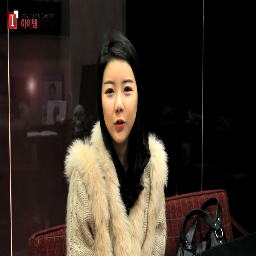

In [ ]:
arr = np.array(train_dataset[0]['np'], dtype=np.uint8)
img = Image.fromarray(arr).convert("RGB")
img

In [ ]:
import gc
del loaded_x_train
del loaded_y_train
del loaded_x_val
del loaded_y_val
del loaded_x_test
del loaded_y_test
gc.collect()

170

In [ ]:
# Apply transformations to dataset
def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(Image.fromarray(np.array(image, dtype=np.uint8)).convert("RGB")) for image in examples['np']]
    # examples['pixel_values'] = [_train_transforms(Image.fromarray(np.load(os.path.join(train_path,image))).convert("RGB")) for image in examples['path']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(Image.fromarray(np.array(image, dtype=np.uint8)).convert("RGB")) for image in examples['np']]
    # examples['pixel_values'] = [_train_transforms(Image.fromarray(np.load(os.path.join(val_path,image))).convert("RGB")) for image in examples['path']]
    return examples

def test_transforms(examples):
    examples['pixel_values'] = [_val_transforms(Image.fromarray(np.array(image, dtype=np.uint8)).convert("RGB")) for image in examples['np']]
    # examples['pixel_values'] = [_train_transforms(Image.fromarray(np.load(os.path.join(val_path,image))).convert("RGB")) for image in examples['path']]
    return examples

In [ ]:
train_dataset.set_transform(train_transforms)
val_dataset.set_transform(val_transforms)
test_dataset.set_transform(test_transforms)

In [ ]:
# Assuming train_data and test_data are loaded datasets


def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example['label'] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

model = SiglipForImageClassification.from_pretrained(model_str, num_labels=len(labels_list))
model.config.id2label = id2label
model.config.label2id = label2id

print(model.num_parameters(only_trainable=True) / 1e6)

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions = eval_pred.predictions
    label_ids = eval_pred.label_ids

    predicted_labels = predictions.argmax(axis=1)
    acc_score = accuracy.compute(predictions=predicted_labels, references=label_ids)['accuracy']

    return {
        "accuracy": acc_score
    }

args = TrainingArguments(
    output_dir="/content/drive/MyDrive/fake_generated_data/siglip2-finetune_2",
    logging_dir='./logs',
    evaluation_strategy="epoch",
    learning_rate=2e-6,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=8,
    num_train_epochs=20,
    weight_decay=0.02,
    warmup_steps=50,
    remove_unused_columns=False,
    save_strategy='epoch',
    load_best_model_at_end=True,
    save_total_limit=1,
    report_to="none"
)

trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

trainer.evaluate()

trainer.train()

trainer.evaluate()

outputs = trainer.predict(val_dataset)
print("======================================final val====================================================")
print(outputs.metrics)
test_output = trainer.predict(test_dataset)
print("======================================final test====================================================")
print(test_output.metrics)

config.json:   0%|          | 0.00/253 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

Some weights of SiglipForImageClassification were not initialized from the model checkpoint at google/siglip2-base-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


92.885762


Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy
1,No log,0.711857,0.003900,0.543333
2,No log,0.693514,0.003900,0.566667
3,No log,0.659884,0.003900,0.610000
4,No log,0.549271,0.003900,0.736667
5,No log,0.444817,0.003900,0.816667
6,0.613300,0.381955,0.003900,0.848333
7,0.613300,0.329579,0.003900,0.870000
8,0.613300,0.284778,0.003900,0.891667
9,0.613300,0.265746,0.003900,0.908333
10,0.613300,0.238425,0.003900,0.911667


# siglip vit and custom lstm

In [1]:
from transformers import SiglipImageProcessor, SiglipVisionModel
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.io import read_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
# train_path = "/content/drive/MyDrive/fake_generated_data/numpy_data/train_np_data.npz"
# val_path = "/content/drive/MyDrive/fake_generated_data/numpy_data/test_np_data.npz"

def load_np_commpressed(path):
  train_data = np.load(path)
  X_train = train_data['X']
  y_train = train_data['y']

  return X_train, y_train

In [3]:
train_path = "/content/drive/MyDrive/fake_generated_data/numpy_data/train_np_data.npz"
loaded_x_train, loaded_y_train = load_np_commpressed(train_path)

val_path = "/content/drive/MyDrive/fake_generated_data/numpy_data/val_np_data.npzl.npz"
loaded_x_val, loaded_y_val = load_np_commpressed(val_path)

test_path = "/content/drive/MyDrive/fake_generated_data/numpy_data/test_np_data.npz"
loaded_x_test, loaded_y_test = load_np_commpressed(test_path)

In [4]:
from datasets import Dataset

train_dataset = Dataset.from_dict({
    "np": loaded_x_train,
    # "path": save_train_paths,
    "label": loaded_y_train  # already small
})

val_dataset = Dataset.from_dict({
    "np": loaded_x_val,
    # "path": save_val_paths,
    "label": loaded_y_val  # already small
})
test_dataset = Dataset.from_dict({
    "np": loaded_x_test,
    # "path": save_val_paths,
    "label": loaded_y_test  # already small
})
train_dataset = train_dataset.shuffle(seed=42)

In [6]:
from torch.utils.data import DataLoader
from PIL import Image
import torchvision.transforms as T

transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# def collate_fn(examples):
#     images = [transform(torch.tensor(example["np"]).permute(2, 0, 1).float() / 255.0) for example in examples]
#     pixel_values = torch.stack(images)
#     labels = torch.tensor([example["label"] for example in examples])
#     return {"pixel_values": pixel_values, "labels": labels}

def collate_fn(examples):
    images = []
    for example in examples:
        img_list = example["np"]  # likely a nested list: [H][W][C]
        img_array = np.array(img_list, dtype=np.uint8)  # convert to NumPy array
        pil_image = Image.fromarray(img_array)
        images.append(transform(pil_image))

    pixel_values = torch.stack(images)
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

# def collate_fn(examples):
#     pixel_values = torch.stack([
#         torch.tensor(example["np"]).permute(2, 0, 1).float()  # HWC -> CHW
#         for example in examples
#     ])
#     labels = torch.tensor([example["label"] for example in examples])
#     return {"pixel_values": pixel_values, "labels": labels}

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset_path = "/content/deepfake_dataset"  # Mount your dataset here
dataset = datasets.ImageFolder(dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Class names
class_names = dataset.classes
print("Classes:", class_names)

In [7]:
image_processor = SiglipImageProcessor.from_pretrained("google/siglip2-base-patch16-224")
vision_encoder = SiglipVisionModel.from_pretrained("google/siglip2-base-patch16-224")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
class DeepfakeClassifier(nn.Module):
    def __init__(self, encoder, embedding_dim=768, freeze_encoder=True):
        super().__init__()
        self.encoder = encoder
        if freeze_encoder:
            for param in self.encoder.parameters():
                param.requires_grad = False

        self.classifier = nn.Sequential(
            nn.Linear(embedding_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
# comment
    def forward(self, x):
        with torch.no_grad():
            features = self.encoder(pixel_values=x).last_hidden_state[:, 0, :]  # [CLS] token
        return self.classifier(features)

In [9]:
import torch
import torch.nn as nn

class DeepfakeLSTMClassifier(nn.Module):
    def __init__(self, encoder, embedding_dim=768, lstm_hidden_dim=196, lstm_layers=1, freeze_encoder=True):
        super().__init__()
        self.encoder = encoder

        if freeze_encoder:
            for param in self.encoder.parameters():
                param.requires_grad = False

        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=lstm_hidden_dim,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=False  # Set True if you want bidirectional LSTM
        )

        self.classifier = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(lstm_hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # print("input shape:", x.shape)
        with torch.no_grad():
            encoder_outputs = self.encoder(pixel_values=x)
            sequence_output = encoder_outputs.last_hidden_state  # shape: (B, seq_len, embedding_dim)
            # print("encoder output shape:", sequence_output.shape)

        # LSTM expects input shape: (B, seq_len, embedding_dim)
        lstm_output, (h_n, c_n) = self.lstm(sequence_output)

        # Use last hidden state (from last LSTM layer)
        final_feature = h_n[-1]  # shape: (B, lstm_hidden_dim)

        return self.classifier(final_feature)


In [10]:
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepfakeLSTMClassifier(vision_encoder).to(device)
# optimizer = torch.optim.Adam(model.classifier.parameters(), lr=1e-4)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5)
criterion = nn.BCELoss()

# for epoch in range(5):
#     model.train()
#     total_loss = 0
#     for images, labels in dataloader:
#         pixel_values = image_processor(images=images, return_tensors="pt")["pixel_values"].to(device)
#         labels = labels.float().unsqueeze(1).to(device)

#         outputs = model(pixel_values)
#         loss = criterion(outputs, labels)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()

#     print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

In [12]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for batch in loader:
        x = batch["pixel_values"].to(device)
        y = batch["labels"].float().to(device)

        optimizer.zero_grad()
        preds = model(x).squeeze(1)  # shape: (batch_size,)
        loss = criterion(preds, y)
        print(f"loss: {loss}")
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    loss =total_loss / len(loader)
    print(f"total loss: {loss}")
    return total_loss / len(loader)


def evaluate(model, loader):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for batch in loader:
            x = batch["pixel_values"].to(device)
            y = batch["labels"].to(device)

            preds = model(x).squeeze(1)
            preds_label = (preds > 0.5).long()

            correct += (preds_label == y).sum().item()
            total += y.size(0)
    acc =correct / total
    print(f"accuracy: {acc}")
    return correct / total

In [ ]:
best_val_acc = 0.0

for epoch in range(1, 21):  # 20 epochs
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    val_acc = evaluate(model, val_loader)

    print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Val Accuracy = {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "/content/drive/MyDrive/fake_generated_data/best_deepfake_model.pt")

loss: 0.7031445503234863
loss: 0.6860437393188477
loss: 0.6902257800102234
loss: 0.6931687593460083
loss: 0.7070547342300415
loss: 0.6916599869728088
loss: 0.6974400281906128
loss: 0.7123888731002808
loss: 0.6916216015815735
loss: 0.6878349781036377
loss: 0.691278338432312
loss: 0.6835364103317261
loss: 0.6954576373100281
loss: 0.6940618753433228
loss: 0.6831926703453064
loss: 0.697986364364624
loss: 0.7157800197601318
loss: 0.6948283910751343
loss: 0.6966297626495361
loss: 0.6903799772262573
loss: 0.7035775780677795
loss: 0.6765762567520142
loss: 0.6937313079833984
loss: 0.6616168022155762
loss: 0.6898398399353027
loss: 0.6983209848403931
loss: 0.6765415668487549
loss: 0.7154867649078369
loss: 0.6893298029899597
loss: 0.6937415599822998
loss: 0.6906235814094543
loss: 0.6913968920707703
loss: 0.6940670013427734
loss: 0.697717547416687
loss: 0.6969559788703918
loss: 0.677064836025238
loss: 0.7001152038574219
loss: 0.6912704706192017
loss: 0.6945861577987671
loss: 0.7161282896995544
loss

In [ ]:
model.eval()
sample, label = dataset[0]
with torch.no_grad():
    input_tensor = image_processor(images=sample, return_tensors="pt")["pixel_values"].to(device)
    pred = model(input_tensor)
    print(f"Prediction: {'Fake' if pred.item() > 0.5 else 'Real'} (Confidence: {pred.item():.2f})")